In [1]:
from pathlib import Path
import os
os.chdir("..")

In [2]:
import lovely_tensors as lt
lt.monkey_patch()

In [3]:
from einops import rearrange
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from PIL import Image
from torchmetrics import F1Score, MetricCollection
from torchvision.transforms.functional import resize
import torch.optim.lr_scheduler as lr_scheduler


import numpy as np
import torch

from fssweed.utils.utils import ResultDict, StrEnum, torch_dict_load, torch_dict_save, to_device
from fssweed.models import build_model
from fssweed.data import get_preprocessing, get_testloaders
from fssweed.data.utils import (
    AnnFileKeys,
    PromptType,
    BatchKeys,
)
from fssweed.substitution import Substitutor
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
def create_rgb_segmentation(segmentation, num_classes=None):
    """
    Convert a segmentation map to an RGB visualization using a precise colormap.

    Args:
        segmentation (torch.Tensor): Segmentation map of shape [B, H, W] where
                                      each pixel contains class labels (natural numbers).
        num_classes (int): The number of unique classes in the segmentation.

    Returns:
        torch.Tensor: RGB visualization of shape [B, 3, H, W].
    """
    if len(segmentation.shape) == 4:
        segmentation = segmentation.argmax(dim=1)
    if num_classes is None:
        num_classes = segmentation.max().item() + 1
    
    # Define a precise colormap for specific classes
    colormap = torch.tensor([
        [0, 0, 0],       # Class 0: Black (Background)
        [0, 128, 0],     # Class 2: Green
        [128, 0, 0],     # Class 1: Red
        [128, 128, 0],   # Class 3: Yellow
        [0, 0, 128],     # Class 4: Blue
        [128, 0, 128],   # Class 5: Magenta
        [0, 128, 128],   # Class 6: Cyan
        [192, 192, 192], # Class 7: Light Gray
    ], dtype=torch.uint8)  # Ensure dtype is uint8

    # Initialize an empty tensor for RGB output
    B, H, W = segmentation.shape
    rgb_segmentation = torch.zeros((B, 3, H, W), dtype=torch.uint8)

    # Loop through each class and assign the corresponding RGB color
    for class_id in range(num_classes):
        # Create a mask for the current class
        class_mask = (segmentation == class_id).unsqueeze(1)  # Shape: [B, 1, H, W]
        # Assign the corresponding color to the rgb_segmentation
        rgb_segmentation += class_mask * colormap[class_id].view(1, 3, 1, 1)  # Broadcasting

    return rgb_segmentation

def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Unnormalize a tensor image with mean and standard deviation.
    
    Args:
        tensor (torch.Tensor): Tensor image of size [B, 3, H, W] to be unnormalized.
        mean (list or tuple): Mean for each channel.
        std (list or tuple): Standard deviation for each channel.
    
    Returns:
        torch.Tensor: Unnormalized tensor image.
    """
    # Ensure the mean and std are tensors and have the correct shape
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device).view(1, 3, 1, 1)
    
    # Unnormalize the tensor
    tensor = tensor * std + mean
    
    return tensor

def batch_visualizer(batch, gt, pred=None):
    assert batch[BatchKeys.PROMPT_MASKS].shape[0] == 1
    masks = batch[BatchKeys.PROMPT_MASKS][0]
    images = batch[BatchKeys.IMAGES][0]
    num_classes = masks.shape[1]
    masks = masks.argmax(dim=1)
    masks = create_rgb_segmentation(masks.cpu(), num_classes=num_classes)
    drawn_gt = create_rgb_segmentation(gt.cpu(), num_classes=num_classes)
    images = torch.cat([unnormalize(image) for image in images]).cpu()
    images = resize(images, gt.shape[-2:])
    masks = torch.cat([drawn_gt, masks], dim=0)
    drawn_batch = torch.stack([images, masks], dim=1)
    if pred is not None:
        drawn_pred = create_rgb_segmentation(pred.cpu(), num_classes=num_classes)
        padding = torch.ones_like(images.unsqueeze(1))
        padding[0] = drawn_pred
        drawn_batch = torch.cat([drawn_batch, padding], dim=1)
    drawn_batch = rearrange(drawn_batch, 'b t c h w -> b c h (t w)')
    return drawn_batch
    

In [5]:
parameters = {
    'dataloader': {'num_workers': 0}, 
    'dataset': {
        'preprocess': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'image_size': 384},
        'datasets': {
            'test_weedmap': {
                'train_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/000',
                'test_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/003',
                'prompt_images': [
                    # 'frame0009_2.png',
                    'frame0021_2.png',
                    'frame0033_3.png',
                    'frame0034_1.png',
                    'frame0048_0.png',
                    ],
                'remove_black_images': False}
            },
    },
    'model': {
        'name': 'dcama',
        'backbone': 'swin',
        'backbone_checkpoint': 'checkpoints/swin_base_patch4_window12_384.pth',
        'model_checkpoint': 'checkpoints/swin_fold0_pascal_modcross_soft.pt',
        # 'model_checkpoint': "checkpoints/swin_fold0.pt",
        'concat_support': False,
        'image_size': 384,
        'train_backbone': True
        }, 
    'refinement': {'lr': 0.01, 'max_iterations': 1000}
}

In [6]:
def exg_refine(image, threshold, prediction):
    img = resize(image, prediction.shape[-2:])
    exg = 2*img[:, 1] - img[:, 0] + img[:, 2]
    exg_mask = ((exg - exg.min())/(exg.max() - exg.min()) > threshold)
    return (exg_mask*prediction) 


In [7]:
preprocess = get_preprocessing(parameters["dataset"])

### Get WeedMap

In [8]:
test_loaders = get_testloaders(
        parameters["dataset"],
        parameters["dataloader"]
    )
weedmap = test_loaders["test_weedmap"]

In [9]:
class FocalLoss(nn.Module):
    def __init__(
        self, gamma: float = 2.0, weights=None
    ):
        super().__init__()
        self.gamma = gamma
        self.weights = weights

        self.reduction = torch.mean

    def __call__(self, x, target):
        ce_loss = F.cross_entropy(x, target, reduction="none")
        pt = torch.exp(-ce_loss)
        
        if self.weights is not None:
            weights = self.weights.to(x.device)[target]
            focal_loss = torch.pow((1 - pt), self.gamma) * weights * ce_loss
        else:
            focal_loss = torch.pow((1 - pt), self.gamma) * ce_loss

        return self.reduction(focal_loss)

### Get Model

In [10]:
device = "cuda"
model = build_model(parameters["model"])
model.to(device)
model.eval()

DCAMAMultiClass(
  (feature_extractor): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=128, input_resolution=(96, 96), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=128, input_resolution=(96, 96), num_heads=4, window_size=12, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=128, window_size=(12, 12), num_heads=4
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax)

In [11]:
state_dict = torch.load("checkpoints/f4z7ghu7.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
from fssweed.models.dcama.distillator import DistilledDCAMA
distilled = DistilledDCAMA(dcama=model, num_classes=2).to(device)

### Get the training data

In [13]:
examples = weedmap.dataset.extract_prompts()
examples = to_device(examples, device)

def get_support_batch(examples):
    support_batch = {
        BatchKeys.IMAGES: examples[BatchKeys.IMAGES].unsqueeze(0).clone(),
        BatchKeys.PROMPT_MASKS: examples[BatchKeys.PROMPT_MASKS].unsqueeze(0).clone(),
        BatchKeys.FLAG_MASKS: examples[BatchKeys.FLAG_MASKS].unsqueeze(0).clone(),
        BatchKeys.FLAG_EXAMPLES: examples[BatchKeys.FLAG_EXAMPLES].unsqueeze(0).clone(),
        BatchKeys.DIMS: examples[BatchKeys.DIMS].unsqueeze(0).clone()
    }
    support_gt = examples[BatchKeys.PROMPT_MASKS].argmax(dim=1).unsqueeze(0)
    return support_batch, support_gt

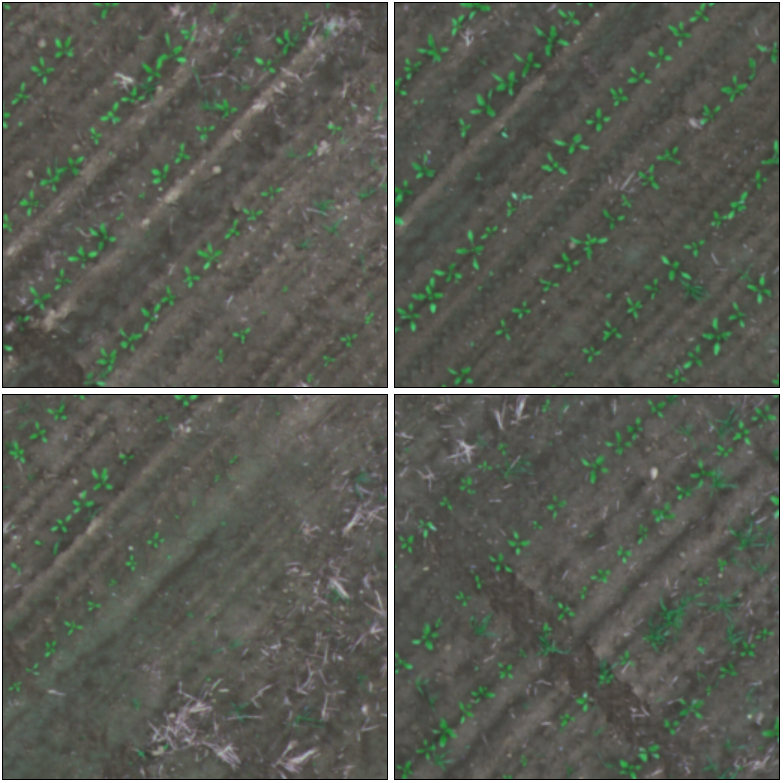

In [14]:
unnormalize(examples[BatchKeys.IMAGES]).rgb

In [15]:
metrics = MetricCollection(
    metrics=[
            F1Score(
                task="multiclass",
                num_classes=weedmap.dataset.num_classes,
                average="macro",
            )
    ]
).to(device)

In [16]:
class DistillationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.logits_loss = FocalLoss()
        self.feature_loss = nn.MSELoss()
    def forward(self, result):
        distilled_logits = result[ResultDict.DISTILLED_LOGITS]
        logits = result[ResultDict.LOGITS]
        
        logits_loss = self.logits_loss(distilled_logits, logits.argmax(dim=1))
        
        coarse_maps = result[ResultDict.COARSE_MASKS]
        distilled_coarse_maps = result[ResultDict.DISTILLED_COARSE]
        
        feature_loss = [
            (self.feature_loss(cm1, dm1) + self.feature_loss(cm2, dm2) + self.feature_loss(cm3, dm3)) / 3
            for (cm1, cm2, cm3), (dm1, dm2, dm3)
            in zip(coarse_maps, distilled_coarse_maps)
        ]
        feature_loss = torch.mean(torch.stack(feature_loss))
        
        return (logits_loss + feature_loss) / 2

In [ ]:
lr = 1.e-3
max_iterations = 50
sched_patience = 10
sched_factor = 0.5
min_lr = 1.e-6

for param in distilled.teacher.parameters():
    param.requires_grad = False
for param in distilled.student.parameters():
    param.requires_grad = True
        
for name, param in distilled.named_parameters():
    if param.requires_grad:
        print(f"Training {name}")
        
support_batch, support_gt = get_support_batch(examples)
_, class_counts = support_gt.unique(return_counts=True)
loss_weights = class_counts.sum() / (2*class_counts)
optimizer = torch.optim.AdamW(distilled.student.parameters(), lr=lr)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=sched_patience, factor=sched_factor, min_lr=min_lr)
# loss_fn = nn.CrossEntropyLoss(weight=loss_weights)
loss_fn = DistillationLoss()

Training student.0.coarse_extractor.0.0.weight
Training student.0.coarse_extractor.0.0.bias
Training student.0.coarse_extractor.0.2.weight
Training student.0.coarse_extractor.0.2.bias
Training student.0.coarse_extractor.1.0.weight
Training student.0.coarse_extractor.1.0.bias
Training student.0.coarse_extractor.1.2.weight
Training student.0.coarse_extractor.1.2.bias
Training student.0.coarse_extractor.2.0.weight
Training student.0.coarse_extractor.2.0.bias
Training student.0.coarse_extractor.2.2.weight
Training student.0.coarse_extractor.2.2.bias
Training student.1.coarse_extractor.0.0.weight
Training student.1.coarse_extractor.0.0.bias
Training student.1.coarse_extractor.0.2.weight
Training student.1.coarse_extractor.0.2.bias
Training student.1.coarse_extractor.1.0.weight
Training student.1.coarse_extractor.1.0.bias
Training student.1.coarse_extractor.1.2.weight
Training student.1.coarse_extractor.1.2.bias
Training student.1.coarse_extractor.2.0.weight
Training student.1.coarse_extract

Training Progress: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s, Loss=0.0207, F1 Score=0.844, Learning Rate=0.001]


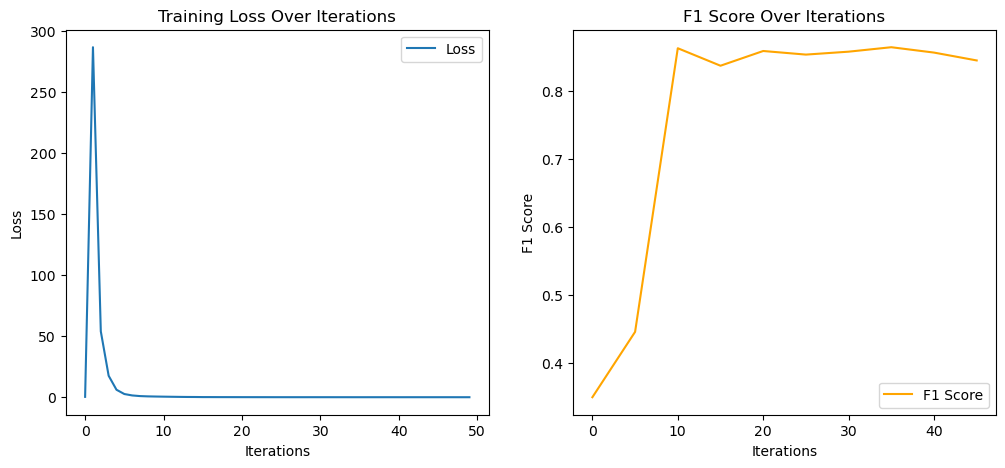

In [18]:
support_batch, support_gt = get_support_batch(examples)
substitutor = Substitutor(substitute=True, subsample=1)
support_set_len = support_batch[BatchKeys.IMAGES].shape[1]
metric_update = 5
metrics.reset()

loss_history = []
f1_history = []

bar = tqdm(range(max_iterations), desc="Training Progress")

for i in bar:
    loss_total = 0
    substitutor.reset(batch=(support_batch, support_gt))
    metrics.reset()
    
    for batch, gt in substitutor:
        result = distilled(batch)
        logits = result[ResultDict.DISTILLED_LOGITS]
        loss_value = loss_fn(result) / support_set_len
        loss_value.backward()
        loss_total += loss_value.item()
        metrics.update(logits.argmax(dim=1), gt)
    
    optimizer.step()
    optimizer.zero_grad()
    
    loss_history.append(loss_total)
    if i % metric_update == 0:
        metric_values = metrics.compute()
        f1_score = metric_values.get("MulticlassF1Score", 0).item()
        f1_history.append(f1_score)
        current_lr = optimizer.param_groups[0]['lr']
    bar.set_postfix({"Loss": loss_total, "F1 Score": f1_score, "Learning Rate": current_lr})

# Plot loss and F1 score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0, max_iterations, metric_update), f1_history, label="F1 Score", color='orange')
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.title("F1 Score Over Iterations")
plt.legend()

plt.show()

In [19]:
substitutor = Substitutor(substitute=True)
support_batch, support_gt = get_support_batch(examples)
support_set_len = support_batch[BatchKeys.IMAGES].shape[1]
metrics.reset()

loss_total = 0
substitutor.reset(batch=(support_batch, support_gt))
for batch, gt in substitutor: 
    with torch.no_grad():
        result = distilled(batch)
    logits = result[ResultDict.DISTILLED_LOGITS]
    metrics.update(logits.argmax(dim=1), gt)
metric_values = metrics.compute()
print("Train metrics: ", metric_values)

Train metrics:  {'MulticlassF1Score': tensor cuda:0 0.857}


In [20]:
substitutor = Substitutor(substitute=True, subsample=1)
substitutor.reset(batch=(support_batch, support_gt))

{'MulticlassF1Score': tensor cuda:0 0.851}


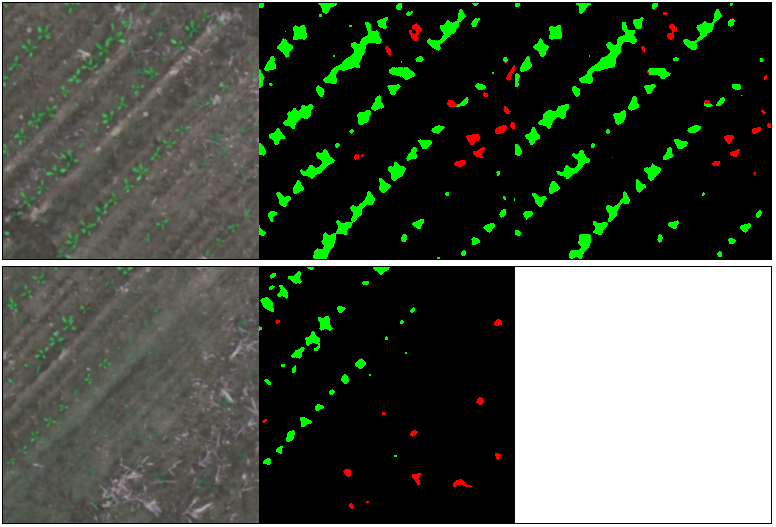

In [21]:
metrics.reset()
try:
    batch, gt = next(substitutor)
    with torch.no_grad():
        result = model(batch)
    logits = result[ResultDict.LOGITS]
    preds = logits.argmax(dim=1)
    print(metrics(preds, gt))
    display(batch_visualizer(batch, gt, pred=preds).rgb)
except StopIteration:
    print("Done")

In [22]:
with torch.no_grad():
    result = model(batch)
    logits = result[ResultDict.LOGITS]

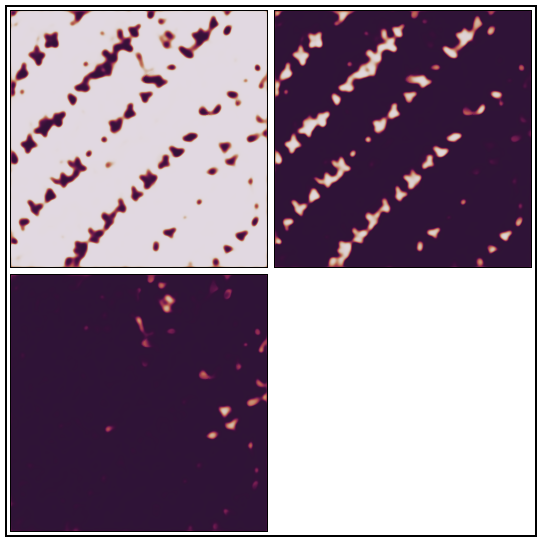

In [23]:
F.softmax(logits, dim=1).chans

### Test everything

In [24]:
from copy import deepcopy

def merge_dicts(prompts, imgs):
    device = imgs[BatchKeys.IMAGES].device
    merge_prompts = deepcopy(prompts)
    out = {}
    for k in set(list(imgs.keys()) + list(merge_prompts.keys())):
        if k in imgs and prompts:
            dim = 0
            if k == BatchKeys.IMAGES:
                merge_prompts[k] = merge_prompts[k].unsqueeze(dim=0)
                dim = 1
            out[k] = torch.cat([imgs[k].cpu(), merge_prompts[k].cpu()], dim=dim).to(
                device
            )
            if k == BatchKeys.DIMS:
                out[k] = out[k].unsqueeze(dim=0).to(device)
        elif k in imgs:
            out[k] = imgs[k].to(device)
        else:
            out[k] = merge_prompts[k].unsqueeze(dim=0).to(device)
    return out

In [27]:
from tqdm import tqdm

metrics.reset()
refined_metrics = metrics.clone()
bar = tqdm(
    enumerate(weedmap),
    total=len(weedmap),
    postfix={"loss": 0},
    desc="Test: ",
)
update_frequency = 10
distilled.eval()
with torch.no_grad():
    for batch_idx, batch_dict in bar:
        image_dict, gt = batch_dict
        input_dict = to_device(merge_dicts(prompts=examples, imgs=image_dict), device)
        gt = to_device(gt, device)
        outputs = distilled(input_dict)[ResultDict.LOGITS]
        outputs = torch.argmax(outputs, dim=1)
        dims = image_dict[BatchKeys.DIMS][0].tolist()
        outputs = outputs[:, : dims[0], : dims[1]]
        refined_outputs = exg_refine(input_dict[BatchKeys.IMAGES][:, 0], 0.20, outputs)
        metrics.update(outputs, gt)
        refined_metrics.update(refined_outputs, gt)
        if batch_idx % update_frequency == 0:
            metrics_values = metrics.compute()
            bar.set_postfix({k: v.item() for k, v in metrics_values.items()})
    metrics_values = metrics.compute()
    refined_metrics_values = refined_metrics.compute()

    for k, v in metrics_values.items():
        print(f"Test - {k}: {v}")
    for k, v in refined_metrics_values.items():
        print(f"Refined Test - {k}: {v}")

Test: 100%|██████████| 408/408 [00:13<00:00, 30.03it/s, MulticlassF1Score=0.766]

Test - MulticlassF1Score: 0.7645754218101501
Refined Test - MulticlassF1Score: 0.7651471495628357


### Qualitative test

In [29]:
iterator = iter(weedmap)

In [46]:
batch_dict  = next(iterator)

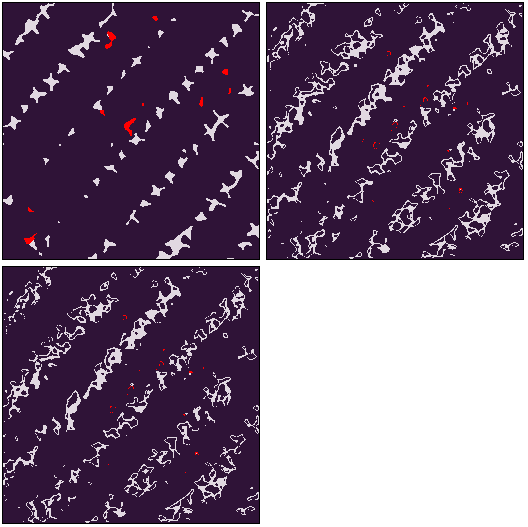

In [47]:
image_dict, gt = batch_dict
input_dict = to_device(merge_dicts(prompts=examples, imgs=image_dict), device)
gt = to_device(gt, device)
outputs = model(input_dict)[ResultDict.LOGITS]
outputs = torch.argmax(outputs, dim=1)

refined = exg_refine(input_dict[BatchKeys.IMAGES][:, 0], 0.20, outputs)

torch.cat([gt, outputs, refined], dim=0).chans